In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint

2023-12-14 21:58:46.401318: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv("Resources/2020_cleaned.csv")
df = df.drop(["BMI", "PhysicalHealthDays", "MentalHealthDays", "AgeCategory", "Race", "GeneralHealth", "HoursOfSleep"], axis=1)
df = df[df['Diabetic'].isin(['Yes', 'No'])] #remove non yes/no diabetic responses
#convert to dummies
df = pd.get_dummies(df)
#drop HD_no so we only have 1 target col
df = df.drop("HeartDisease_No", axis=1)
#convert to 1/0 
df = df.astype(int)
df.head()

,HeartDisease_Yes,Smoking_No,Smoking_Yes,AlcoholDrinking_No,AlcoholDrinking_Yes,Stroke_No,Stroke_Yes,DifficultyWalking_No,DifficultyWalking_Yes,Sex_Female,...,Diabetic_No,Diabetic_Yes,PhysicalActivities_No,PhysicalActivities_Yes,Asthma_No,Asthma_Yes,KidneyDisease_No,KidneyDisease_Yes,SkinCancer_No,SkinCancer_Yes
0,0,0,1,1,0,1,0,1,0,1,...,0,1,0,1,0,1,1,0,0,1
1,0,1,0,1,0,0,1,1,0,1,...,1,0,0,1,1,0,1,0,1,0
2,0,0,1,1,0,1,0,1,0,0,...,0,1,0,1,0,1,1,0,1,0
3,0,1,0,1,0,1,0,1,0,1,...,1,0,1,0,1,0,1,0,0,1
4,0,1,0,1,0,1,0,0,1,1,...,1,0,0,1,1,0,1,0,1,0


In [3]:
#set feature/ target cols & train/test data before any resampling
target = df['HeartDisease_Yes']
features = df.drop(['HeartDisease_Yes'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42, test_size=0.5)

In [4]:
#undersampling: randomly remove portion of rows with "No" responses only from training data
#removed 90% of "No" responses b/c ratio of "No" to "Yes" was ~10:1 (91% n, 9% y)
#put training data back together
train_data = pd.concat([X_train, y_train], axis=1)

# define yes/no classes in heartdisease_yes col 
majority_class_train = train_data[train_data['HeartDisease_Yes'] == 0]
minority_class_train = train_data[train_data['HeartDisease_Yes'] == 1]

# undersample majority class (no/0)
undersampled_majority_train = resample(majority_class_train, replace=False, n_samples=int(0.2 * len(minority_class_train)), random_state=42)

# put no and yes back together
train_resampled = pd.concat([undersampled_majority_train, minority_class_train])

# set feature & target cols again w/ resampled train data
y_train_resampled = train_resampled['HeartDisease_Yes']
X_train_resampled = train_resampled.drop('HeartDisease_Yes', axis=1)

In [5]:
#model structure
nn = tf.keras.models.Sequential()
nn.add(tf.keras.layers.Dense(units=15, activation='relu', input_dim=X_train_resampled.shape[1]))
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                315       
                                                                 
 dense_1 (Dense)             (None, 1)                 16        
                                                                 
Total params: 331 (1.29 KB)
Trainable params: 331 (1.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
# save weights callback
checkpoint_path = "model2_checkpoint/checkpoint_{epoch:02d}"
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_freq=1)

In [7]:
# compile model
nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
# train model 
model = nn.fit(X_train_resampled.values, y_train_resampled.values, epochs=1, callbacks=[checkpoint_callback], verbose=2, validation_split=0.5)

248/248 - 5s - loss: 0.5727 - accuracy: 0.6924 - val_loss: 0.3142 - val_accuracy: 0.9508 - 5s/epoch - 21ms/step


In [9]:
#predictions for classification report
y_pred = nn.predict(X_test.values)
y_pred_classes = (y_pred > 0.5).astype(int)
# classification report
report = classification_report(y_test.values, y_pred_classes)
print(report)

4851/4851 [==============================] - 5s 923us/step
              precision    recall  f1-score   support

           0       0.98      0.22      0.36    141962
           1       0.10      0.95      0.18     13266

    accuracy                           0.28    155228
   macro avg       0.54      0.58      0.27    155228
weighted avg       0.90      0.28      0.34    155228



In [10]:
#get weights
weights = nn.get_weights()
layer1_weights = weights[0]
feature_names = X_train.columns
feature_weights = dict(zip(feature_names, layer1_weights))
sorted_features = sorted(feature_weights.items(), key=lambda x: x[1].max(), reverse=True)
for feature, weight in sorted_features:
    print(f"{weight.max():.3}, {feature}")

0.504, Stroke_Yes
0.487, SkinCancer_No
0.481, DifficultyWalking_Yes
0.479, Diabetic_Yes
0.462, KidneyDisease_Yes
0.442, SkinCancer_Yes
0.419, PhysicalActivities_Yes
0.415, Asthma_Yes
0.411, Sex_Female
0.392, AlcoholDrinking_No
0.373, Asthma_No
0.372, Sex_Male
0.354, Stroke_No
0.353, AlcoholDrinking_Yes
0.344, DifficultyWalking_No
0.34, PhysicalActivities_No
0.332, Smoking_Yes
0.331, Smoking_No
0.316, KidneyDisease_No
0.305, Diabetic_No


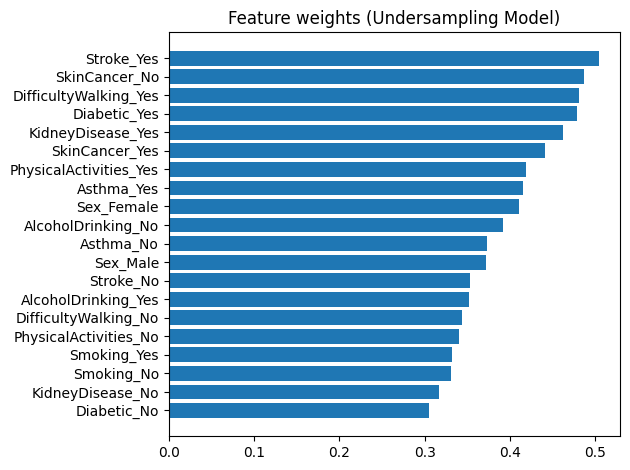

In [11]:
#plot weights
sorted_features = sorted(sorted_features, key=lambda x: x[1].max(), reverse=True)
features, weights = zip(*sorted_features)
positions = np.arange(len(features))
plt.barh(positions, [weight.max() for weight in weights])
plt.yticks(positions, features)
plt.title('Feature weights (Undersampling Model)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()